In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue'

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

page = requests.get(url, headers=headers)

soup = BeautifulSoup(page.text, "html.parser")

In [4]:
table = soup.find("table", {"class": "wikitable sortable"})

In [5]:
headers = [th.text.strip() for th in table.find_all("th")]

In [6]:
rows = []
for tr in table.find_all("tr")[1:]:
    tds = tr.find_all("td")
    if len(tds) == len(headers):
        rows.append([td.text.strip() for td in tds])

In [7]:
df_wiki = pd.DataFrame(rows, columns=headers)

In [8]:
len(df_wiki)

100

In [51]:
df_wiki

,Rank,Company,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters
0,1,Walmart,Retail,"680,985",5.1%,"2,100,000","Bentonville, Arkansas"
1,2,Amazon,Retail and cloud computing,"637,959",11.0%,"1,556,000","Seattle, Washington"
2,3,UnitedHealth Group,Healthcare,"400,278",7.7%,"400,000","Minnetonka, Minnesota"
3,4,Apple,Electronics industry,"391,035",2.0%,"164,000","Cupertino, California"
4,5,CVS Health,Healthcare,"372,809",4.2%,"259,500","Woonsocket, Rhode Island"
...,...,...,...,...,...,...,...
95,96,General Dynamics,Aerospace and defense,"47,716",12.9%,"117,000","Reston, Virginia"
96,97,Coca-Cola,Beverage,"47,061",2.9%,"69,700","Atlanta, Georgia"
97,98,TIAA,Financials,"46,946",2.6%,"15,623","New York City, New York"
98,99,The Travelers Companies,Insurance,"46,423",12.2%,"34,000","New York City, New York"


In [10]:
df_wiki = df_wiki.rename(columns={'Name': 'Company'})



In [57]:
df_wiki.to_csv("df_wiki.csv", index=False)


In [11]:
df_wiki['Company'] = df_wiki['Company'].str.strip()


In [12]:
companies = df_wiki["Company"].tolist()
len(companies)


100

In [13]:
print(companies[:10])


['Walmart', 'Amazon', 'UnitedHealth Group', 'Apple', 'CVS Health', 'Berkshire Hathaway', 'Alphabet', 'ExxonMobil', 'McKesson Corporation', 'Cencora']


In [14]:
#API for matching name of company with their symbol
import finnhub
api_key = "d3t3huhr01qqdgfu1rngd3t3huhr01qqdgfu1ro0"
finnhub_client = finnhub.Client(api_key=api_key)


In [15]:
#Testing of company name in Finhub database
#We find 11 matches for company with "Apple" in thier name
result = finnhub_client.symbol_lookup("Apple")
print(result)


{'count': 11, 'result': [{'description': 'Apple Inc', 'displaySymbol': 'AAPL', 'symbol': 'AAPL', 'type': 'Common Stock'}, {'description': 'Apple Hospitality REIT Inc', 'displaySymbol': 'APLE', 'symbol': 'APLE', 'type': 'Common Stock'}, {'description': 'Apple Flavor & Fragrance Group Co Ltd', 'displaySymbol': '603020.SS', 'symbol': '603020.SS', 'type': 'Common Stock'}, {'description': 'Maui Land & Pineapple Company Inc', 'displaySymbol': 'MLP', 'symbol': 'MLP', 'type': 'Common Stock'}, {'description': 'Apple iSports Group Inc', 'displaySymbol': 'AAPI', 'symbol': 'AAPI', 'type': 'Common Stock'}, {'description': 'Apple International Co Ltd', 'displaySymbol': '2788.T', 'symbol': '2788.T', 'type': 'Common Stock'}, {'description': 'Applepark Co Ltd', 'displaySymbol': '164A.T', 'symbol': '164A.T', 'type': 'Common Stock'}, {'description': 'Pineapple Inc', 'displaySymbol': 'PNPL', 'symbol': 'PNPL', 'type': 'Common Stock'}, {'description': 'Pineapple Resources Bhd', 'displaySymbol': 'PINEAPP.KL'

In [ ]:
#We need to divide them 2 groups, because api has 60 requests per min
first_batch = companies[:50]
second_batch = companies[50:]

In [ ]:
from thefuzz import fuzz, process
import finnhub
import pandas as pd
import time  # for delays
import yaml

# Load API keys from config file
with open("api_config.yaml", "r") as file:
    config = yaml.safe_load(file)

finnhub_api_key = config.get("finhub_api_key")
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

final_data = []

def fetch_symbols(batch):
    for name in batch:
        query = name[:20]
        result = finnhub_client.symbol_lookup(query)
        
        if result['count'] > 0:
            candidates = result['result']
            descriptions = [c['description'] for c in candidates]

            best_match, score = process.extractOne(name, descriptions, scorer=fuzz.token_set_ratio)
            matched_item = next((c for c in candidates if c['description'] == best_match), None)

            if matched_item:
                final_data.append({
                    "Company": name,
                    "Best_Match": best_match,
                    "Symbol": matched_item['symbol'],
                    "Score": score
                })
            else:
                final_data.append({
                    "Company": name,
                    "Best_Match": None,
                    "Symbol": None,
                    "Score": None
                })
        else:
            final_data.append({
                "Company": name,
                "Best_Match": None,
                "Symbol": None,
                "Score": None
            })

# First batch
first_batch = companies[:50]
fetch_symbols(first_batch)

# Wait 60 seconds (or longer if needed) before second batch
time.sleep(60)

# Second batch
second_batch = companies[50:]
fetch_symbols(second_batch)

# Final DataFrame
df_symbol = pd.DataFrame(final_data)
print(df_symbol)


                    Company              Best_Match     Symbol  Score
0                   Walmart             Walmart Inc        WMT  100.0
1                    Amazon          Amazon.com Inc       AMZN  100.0
2        UnitedHealth Group  UnitedHealth Group Inc        UNH  100.0
3                     Apple               Apple Inc       AAPL  100.0
4                CVS Health         CVS Health Corp        CVS  100.0
..                      ...                     ...        ...    ...
95         General Dynamics   General Dynamics Corp         GD  100.0
96                Coca-Cola            Coca-Cola Co         KO  100.0
97                     TIAA      Tiaan Consumer Ltd  540108.BO   36.0
98  The Travelers Companies                    None       None    NaN
99                Eli Lilly        Eli Lilly and Co        LLY  100.0

[100 rows x 4 columns]


In [56]:
df_symbol.to_csv("df_symbol.csv", index=False)


In [166]:
df_wiki

,Rank,Company,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters
0,1,Walmart,Retail,"680,985",5.1%,"2,100,000","Bentonville, Arkansas"
1,2,Amazon,Retail and cloud computing,"637,959",11.0%,"1,556,000","Seattle, Washington"
2,3,UnitedHealth Group,Healthcare,"400,278",7.7%,"400,000","Minnetonka, Minnesota"
3,4,Apple,Electronics industry,"391,035",2.0%,"164,000","Cupertino, California"
4,5,CVS Health,Healthcare,"372,809",4.2%,"259,500","Woonsocket, Rhode Island"
...,...,...,...,...,...,...,...
95,96,General Dynamics,Aerospace and defense,"47,716",12.9%,"117,000","Reston, Virginia"
96,97,Coca-Cola,Beverage,"47,061",2.9%,"69,700","Atlanta, Georgia"
97,98,TIAA,Financials,"46,946",2.6%,"15,623","New York City, New York"
98,99,The Travelers Companies,Insurance,"46,423",12.2%,"34,000","New York City, New York"


In [19]:
df_merged = df_wiki.merge(df_symbol[['Company', 'Symbol']], on='Company', how='left')





In [ ]:
df_merged

In [106]:
print(df_merged.head())
print(" Total rows:", len(df_merged))
print(" Matched Symbols:", df_merged['Symbol'].notna().sum())
print(" Missing symbols:", df_merged['Symbol'].isna().sum())

  Rank             Company                    Industry Revenue (USD millions)  \
0    1             Walmart                      Retail                680,985   
1    2              Amazon  Retail and cloud computing                637,959   
2    3  UnitedHealth Group                  Healthcare                400,278   
3    4               Apple        Electronics industry                391,035   
4    5          CVS Health                  Healthcare                372,809   

  Revenue growth  Employees              Headquarters Symbol  
0           5.1%  2,100,000     Bentonville, Arkansas    WMT  
1          11.0%  1,556,000       Seattle, Washington   AMZN  
2           7.7%    400,000     Minnetonka, Minnesota    UNH  
3           2.0%    164,000     Cupertino, California   AAPL  
4           4.2%    259,500  Woonsocket, Rhode Island    CVS  
 Total rows: 77
 Matched Symbols: 77
 Missing symbols: 0


In [22]:
df_missing = df_merged[df_merged['Symbol'].isna()]
print("Companies with missing symbols:")
print(df_missing['Company'].tolist())


Companies with missing symbols:
['ExxonMobil', 'McKesson Corporation', 'Chevron Corporation', 'Ford Motor Company', 'The Home Depot', 'Fannie Mae', 'State Farm', 'Freddie Mac', 'Target Corporation', 'The Walt Disney Company', 'Archer Daniels Midland', 'Energy Transfer Partners', 'RTX Corporation', 'Progressive Corporation', 'Merck & Co.', 'New York Life Insurance Company', 'Publix', 'Nationwide Mutual Insurance Company', 'Oracle Corporation', 'John Deere', 'Liberty Mutual', 'USAA', 'The Travelers Companies']


In [23]:
df_merged = df_merged[df_merged['Symbol'].notna()]


In [25]:
df_merged = df_merged.reset_index(drop=True)
df_merged

,Rank,Company,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters,Symbol
0,1,Walmart,Retail,"680,985",5.1%,"2,100,000","Bentonville, Arkansas",WMT
1,2,Amazon,Retail and cloud computing,"637,959",11.0%,"1,556,000","Seattle, Washington",AMZN
2,3,UnitedHealth Group,Healthcare,"400,278",7.7%,"400,000","Minnetonka, Minnesota",UNH
3,4,Apple,Electronics industry,"391,035",2.0%,"164,000","Cupertino, California",AAPL
4,5,CVS Health,Healthcare,"372,809",4.2%,"259,500","Woonsocket, Rhode Island",CVS
...,...,...,...,...,...,...,...,...
72,95,Ingram Micro,Technology,"47,984",-0.1%,"26,125","Irvine, California",INGM
73,96,General Dynamics,Aerospace and defense,"47,716",12.9%,"117,000","Reston, Virginia",GD
74,97,Coca-Cola,Beverage,"47,061",2.9%,"69,700","Atlanta, Georgia",KO
75,98,TIAA,Financials,"46,946",2.6%,"15,623","New York City, New York",540108.BO


In [60]:
df_merged.to_csv("df_merged.csv", index=False)


In [26]:
df_merged['Symbol'] = df_merged['Symbol'].str.strip()

In [27]:
len(df_merged['Symbol'])

77

In [ ]:
#api test

api_key = "kT2OQrwq84sf88N7PYmDOLYb1uhbdRkZ"  # replace with your real API key later 
company = "APPL"
url1=f"https://financialmodelingprep.com/stable/profile?symbol=AAPL&apikey=kT2OQrwq84sf88N7PYmDOLYb1uhbdRkZ"
url =f"https://financialmodelingprep.com/stable/profile?symbol={company}&apikey={api_key}"

r = requests.get(url1)
print(r.json())



[{'symbol': 'AAPL', 'price': 260.385, 'marketCap': 3864214950150, 'beta': 1.094, 'lastDividend': 1.02, 'range': '169.21-265.29', 'change': 1.935, 'changePercentage': 0.74869, 'volume': 11915338, 'averageVolume': 54967137, 'companyName': 'Apple Inc.', 'currency': 'USD', 'cik': '0000320193', 'isin': 'US0378331005', 'cusip': '037833100', 'exchangeFullName': 'NASDAQ Global Select', 'exchange': 'NASDAQ', 'industry': 'Consumer Electronics', 'website': 'https://www.apple.com', 'description': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and do

In [ ]:
import requests
import pandas as pd
import time
import yaml

with open("api_config.yaml", "r") as file:
    config = yaml.safe_load(file)

api_key = config.get("fdp_api_key")

#symbols = df_wiki['Symbol'].tolist()
symbols = df_merged['Symbol'].tolist()
profiles = []

for company in symbols:
    url = f"https://financialmodelingprep.com/stable/profile?symbol={company}&apikey={api_key}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        if data:  # make sure list is not empty
            profiles.append(data[0])  # data is returned as a list with 1 dict
    else:
        print(f"X Failed for {company}: {response.status_code}")
    
    # optional: small delay to be polite
    time.sleep(0.1)

# Convert to DataFrame
df_api = pd.DataFrame(profiles)

# Check result
print(df_api.head())



⚠️ Failed for GD: 429
⚠️ Failed for KO: 429
⚠️ Failed for 540108.BO: 429
⚠️ Failed for LLY: 429
  symbol    price      marketCap   beta  lastDividend          range  change  \
0    WMT  106.040   845441132977  0.671        0.9125   79.81-109.58  -1.100   
1   AMZN  220.420  2350759924421  1.281        0.0000  161.38-242.52   2.470   
2    UNH  360.315   326327792192  0.478        8.6200   234.6-630.73  -1.175   
3   AAPL  260.060  3859391823400  1.094        1.0200  169.21-265.29   1.610   
4    CVS   80.940   102658336793  0.609        1.9950    43.56-83.52  -1.070   

   changePercentage    volume  averageVolume  ...          city state  \
0          -1.02669   4278415     16517159.0  ...   Bentonville    AR   
1           1.13329  14170486     44254714.0  ...       Seattle    WA   
2          -0.32504   3193817     15174048.0  ...  Eden Prairie    MN   
3           0.62294  13014414     54967137.0  ...     Cupertino    CA   
4          -1.30472   2713106      7853815.1  ...    Woons

In [32]:
df_api

,symbol,price,marketCap,beta,lastDividend,range,change,changePercentage,volume,averageVolume,...,city,state,zip,image,ipoDate,defaultImage,isEtf,isActivelyTrading,isAdr,isFund
0,WMT,106.040,845441132977,0.671000,0.9125,79.81-109.58,-1.100,-1.02669,4278415,16517159.0,...,Bentonville,AR,72716,https://images.financialmodelingprep.com/symbo...,1972-08-25,False,False,True,False,False
1,AMZN,220.420,2350759924421,1.281000,0.0000,161.38-242.52,2.470,1.13329,14170486,44254714.0,...,Seattle,WA,98109-5210,https://images.financialmodelingprep.com/symbo...,1997-05-15,False,False,True,False,False
2,UNH,360.315,326327792192,0.478000,8.6200,234.6-630.73,-1.175,-0.32504,3193817,15174048.0,...,Eden Prairie,MN,55343,https://images.financialmodelingprep.com/symbo...,1984-10-17,False,False,True,False,False
3,AAPL,260.060,3859391823400,1.094000,1.0200,169.21-265.29,1.610,0.62294,13014414,54967137.0,...,Cupertino,CA,95014,https://images.financialmodelingprep.com/symbo...,1980-12-12,False,False,True,False,False
4,CVS,80.940,102658336793,0.609000,1.9950,43.56-83.52,-1.070,-1.30472,2713106,7853815.1,...,Woonsocket,RI,02895,https://images.financialmodelingprep.com/symbo...,1996-11-20,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,INTC,37.550,164351968103,1.330000,0.1250,17.67-39.65,0.630,1.70639,37409153,126040262.0,...,Santa Clara,CA,95054-1549,https://images.financialmodelingprep.com/symbo...,1980-03-17,False,False,True,False,False
66,AVGO,344.735,1619646371947,1.208000,2.3600,138.1-374.23,4.435,1.30326,5112007,22777687.0,...,Palo Alto,CA,94304,https://images.financialmodelingprep.com/symbo...,2009-08-06,False,False,True,False,False
67,PAA,16.725,11762766960,0.712000,1.4575,15.58-21,0.215,1.30224,2931064,2892554.0,...,Houston,TX,77002,https://images.financialmodelingprep.com/symbo...,1998-11-18,False,False,True,False,False
68,BMY,43.915,89386164826,0.344000,2.4800,42.96-63.33,-0.475,-1.07006,5438971,13903093.0,...,Princeton,NY,10016,https://images.financialmodelingprep.com/symbo...,1972-06-01,False,False,True,False,False


In [61]:
df_api.to_csv("df_api.csv", index=False)


In [47]:
df_api_selected = df_api[['symbol','price', 'marketCap', 'beta', 'lastDividend', 'range', 'change', 
'changePercentage', 'volume', 'averageVolume', 'ceo','state']]


In [43]:
df_api_selected

,symbol,price,marketCap,beta,lastDividend,range,change,changePercentage,volume,averageVolume,ceo
0,WMT,106.040,845441132977,0.671000,0.9125,79.81-109.58,-1.100,-1.02669,4278415,16517159.0,C. Douglas McMillon
1,AMZN,220.420,2350759924421,1.281000,0.0000,161.38-242.52,2.470,1.13329,14170486,44254714.0,Andrew R. Jassy
2,UNH,360.315,326327792192,0.478000,8.6200,234.6-630.73,-1.175,-0.32504,3193817,15174048.0,Stephen J. Hemsley
3,AAPL,260.060,3859391823400,1.094000,1.0200,169.21-265.29,1.610,0.62294,13014414,54967137.0,Timothy D. Cook
4,CVS,80.940,102658336793,0.609000,1.9950,43.56-83.52,-1.070,-1.30472,2713106,7853815.1,J. David Joyner CEBS
...,...,...,...,...,...,...,...,...,...,...,...
65,INTC,37.550,164351968103,1.330000,0.1250,17.67-39.65,0.630,1.70639,37409153,126040262.0,Lip-Bu Tan
66,AVGO,344.735,1619646371947,1.208000,2.3600,138.1-374.23,4.435,1.30326,5112007,22777687.0,Hock E. Tan
67,PAA,16.725,11762766960,0.712000,1.4575,15.58-21,0.215,1.30224,2931064,2892554.0,Wilfred C.W. Chiang
68,BMY,43.915,89386164826,0.344000,2.4800,42.96-63.33,-0.475,-1.07006,5438971,13903093.0,Christopher S. Boerner


In [48]:
df_final = df_merged.merge(df_api_selected, left_on='Symbol', right_on='symbol', how='left')


In [72]:
df_final = df_final.reset_index(drop=True)

In [75]:
df_final

,Rank,Company,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters,Symbol,symbol,price,marketCap,beta,lastDividend,range,change,changePercentage,volume,averageVolume,ceo,state
0,1,Walmart,Retail,"680,985",5.1%,"2,100,000","Bentonville, Arkansas",WMT,WMT,106.040,8.454411e+11,0.671000,0.9125,79.81-109.58,-1.100,-1.02669,4278415.0,16517159.0,C. Douglas McMillon,AR
1,2,Amazon,Retail and cloud computing,"637,959",11.0%,"1,556,000","Seattle, Washington",AMZN,AMZN,220.420,2.350760e+12,1.281000,0.0000,161.38-242.52,2.470,1.13329,14170486.0,44254714.0,Andrew R. Jassy,WA
2,3,UnitedHealth Group,Healthcare,"400,278",7.7%,"400,000","Minnetonka, Minnesota",UNH,UNH,360.315,3.263278e+11,0.478000,8.6200,234.6-630.73,-1.175,-0.32504,3193817.0,15174048.0,Stephen J. Hemsley,MN
3,4,Apple,Electronics industry,"391,035",2.0%,"164,000","Cupertino, California",AAPL,AAPL,260.060,3.859392e+12,1.094000,1.0200,169.21-265.29,1.610,0.62294,13014414.0,54967137.0,Timothy D. Cook,CA
4,5,CVS Health,Healthcare,"372,809",4.2%,"259,500","Woonsocket, Rhode Island",CVS,CVS,80.940,1.026583e+11,0.609000,1.9950,43.56-83.52,-1.070,-1.30472,2713106.0,7853815.1,J. David Joyner CEBS,RI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,95,Ingram Micro,Technology,"47,984",-0.1%,"26,125","Irvine, California",INGM,INGM,21.510,5.051494e+09,2.312554,0.3100,14.25-25.69,0.130,0.60804,127463.0,323332.0,Paul D. Bay,CA
73,96,General Dynamics,Aerospace and defense,"47,716",12.9%,"117,000","Reston, Virginia",GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,97,Coca-Cola,Beverage,"47,061",2.9%,"69,700","Atlanta, Georgia",KO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,98,TIAA,Financials,"46,946",2.6%,"15,623","New York City, New York",540108.BO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Remove unwanted column (replace 'column_to_remove' with actual column name)
df_final = df_final.drop(columns=['Symbol'])




In [82]:
# Remove rows where 'symbol' is empty or null
df_final = df_final[df_final['symbol'].notna() & (df_final['symbol'] != '')]

In [86]:
# Reset Rank from 1 to len(dp_final)
df_final = df_final.reset_index(drop=True)  # reset index first
df_final['Rank'] = range(1, len(df_final) + 1)

In [102]:
df_final.to_csv("df_final1.csv", index=False)


In [101]:
print(df_final.dtypes)

Rank                        int64
Company                    object
Industry                   object
Revenue (USD millions)      int64
Revenue growth            float64
Employees                   int64
Headquarters               object
symbol                     object
price                     float64
marketCap                 float64
beta                      float64
lastDividend              float64
range                      object
change                    float64
changePercentage          float64
volume                      Int64
averageVolume             float64
ceo                        object
state                      object
dtype: object


In [ ]:
# Revenue (USD millions)
df_final['Revenue (USD millions)'] = pd.to_numeric(
    df_final['Revenue (USD millions)'].astype(str).str.replace(',', ''), 
    errors='coerce'
)

# Revenue growth
df_final['Revenue growth'] = pd.to_numeric(
    df_final['Revenue growth'].astype(str).str.replace('%', ''), 
    errors='coerce'
)

# Employees
df_final['Employees'] = pd.to_numeric(
    df_final['Employees'].astype(str).str.replace(',', ''), 
    errors='coerce'
)

# Nullable integers for volumes
df_final['volume'] = pd.to_numeric(df_final['volume'], errors='coerce').astype('Int64')



/tmp/ipykernel_28566/2434375011.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Company', y='Revenue (USD millions)', data=top10, palette='viridis')


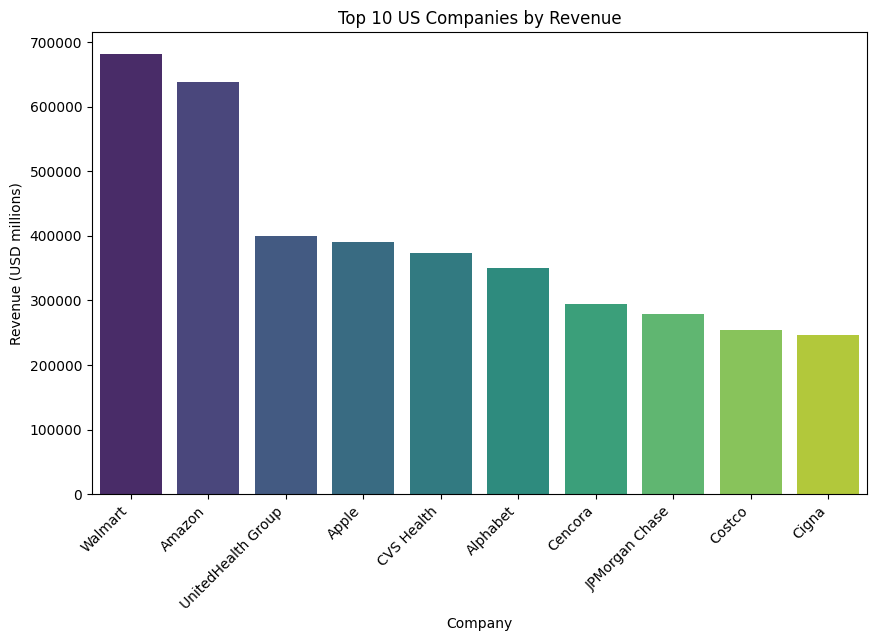

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 by Revenue
top10 = df_final.nlargest(10, 'Revenue (USD millions)')

plt.figure(figsize=(10,6))
sns.barplot(x='Company', y='Revenue (USD millions)', data=top10, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 US Companies by Revenue")
plt.ylabel("Revenue (USD millions)")
plt.xlabel("Company")
plt.show()


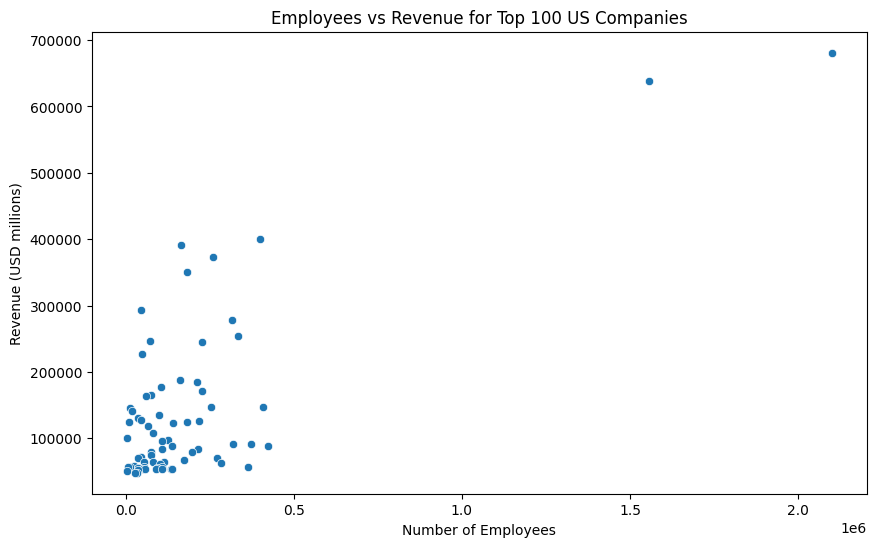

In [104]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Employees', y='Revenue (USD millions)', data=df_final)
plt.title("Employees vs Revenue for Top 100 US Companies")
plt.xlabel("Number of Employees")
plt.ylabel("Revenue (USD millions)")
plt.show()


/tmp/ipykernel_28566/3764847246.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_growth.index, y=avg_growth.values, palette='coolwarm')


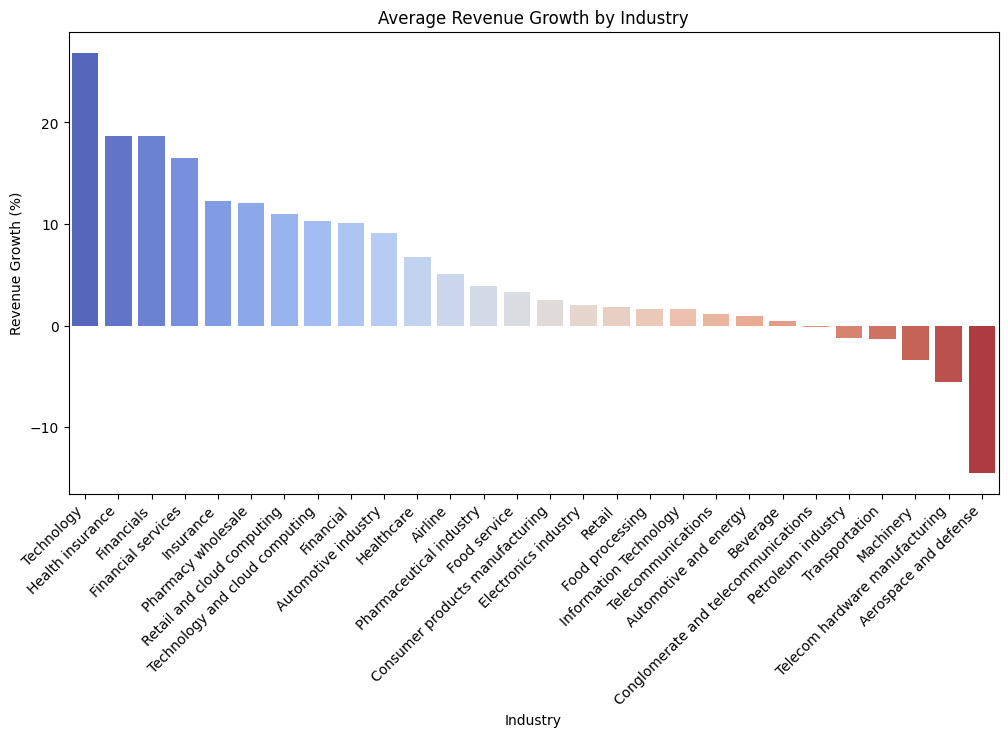

In [105]:
plt.figure(figsize=(12,6))
avg_growth = df_final.groupby('Industry')['Revenue growth'].mean().sort_values(ascending=False)
sns.barplot(x=avg_growth.index, y=avg_growth.values, palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title("Average Revenue Growth by Industry")
plt.ylabel("Revenue Growth (%)")
plt.xlabel("Industry")
plt.show()
